In [34]:
%load_ext autoreload
%autoreload 2

from tqdm.notebook import tqdm
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

from py.Dataset import Dataset
from py.DatasetStatistics import DatasetStatistics
from py.Session import Session
from py.FileUtils import list_folders, list_jpegs_recursive
from py.ImageUtils import display_images

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
DIR = '/home/AMMOD_data/camera_traps/BayerWald/Vielkadaver-Projekt/'

ds = Dataset(DIR)
session = ds.create_session("beaver_01")

Found 32 sessions
Session 'Beaver_01' at folder: /home/AMMOD_data/camera_traps/BayerWald/Vielkadaver-Projekt/VIELAAS_Spring_Session01-VIELAAS_Beaver_01
Loaded scans.


In [218]:
img = session.get_random_motion_image(day_only=True)

In [219]:
previous_img, next_img, rel = img.get_closest_lapse_images()
print(rel)

0.7741666666666667


In [220]:
scale = 0.5
img1 = previous_img.read(gray=True, scale=scale) / 255.
img2 = img.read(gray=True, scale=scale) / 255.
img3 = next_img.read(gray=True, scale=scale) / 255.
# previous_img.open()
# img.open()
# next_img.open()

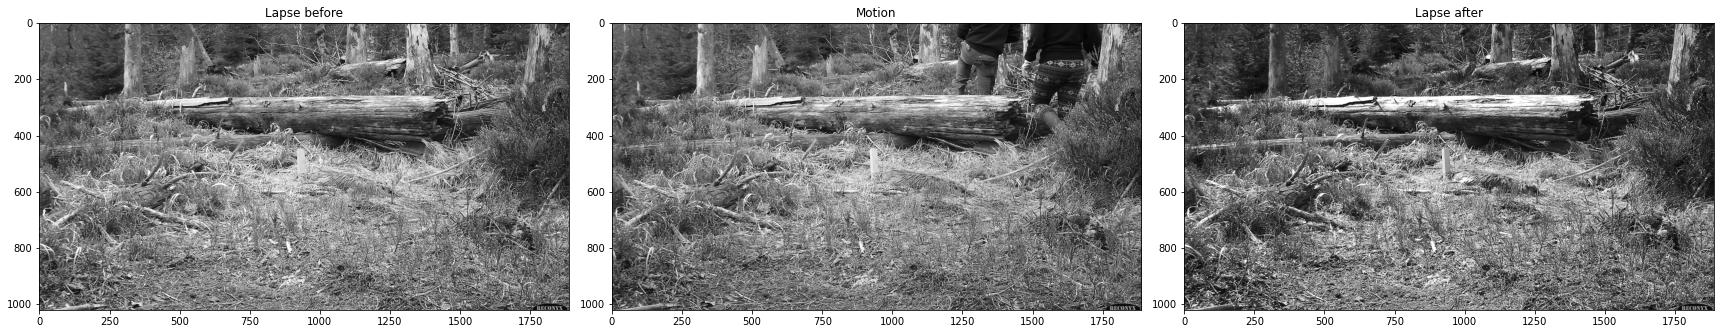

In [221]:
display_images([img1, img2, img3], ["Lapse before", "Motion", "Lapse after"], cmap="gray")

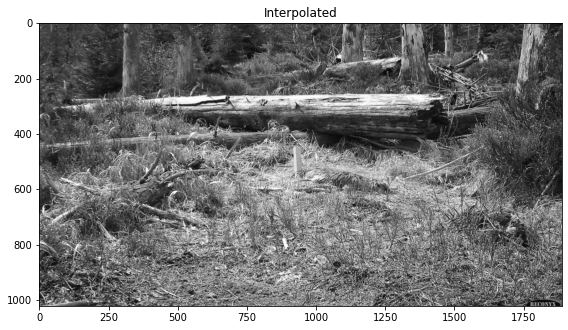

In [222]:
interpol = rel * img3 + (1 - rel) * img1
display_images([interpol], ["Interpolated"], cmap="gray")

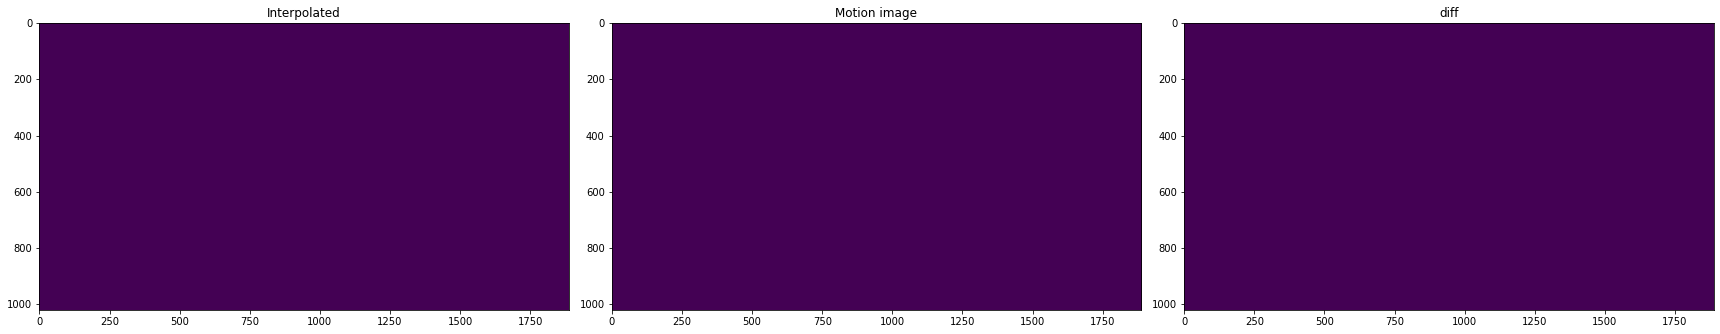

In [228]:
from skimage.metrics import structural_similarity
from skimage.transform import rescale
from skimage.color import rgb2gray
from skimage.feature import canny
cinterpol = canny(interpol)
cimg2 = canny(img2)
display_images([cinterpol, cimg2, cimg2 ^ cinterpol], ["Interpolated", "Motion image", "diff"])

In [229]:
def normalize(img):
    return (img - np.mean(img)) / np.std(img)

0.3773886191826087


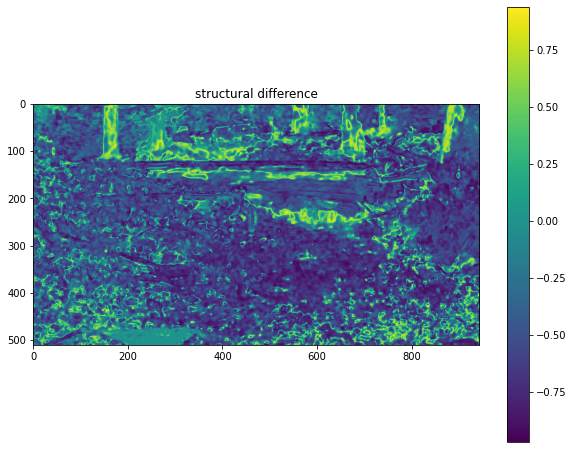

In [230]:
mssim, S = structural_similarity(normalize(interpol_), normalize(img2_), full=True)
plt.figure(figsize=(10, 8))
plt.imshow(-S)
plt.colorbar()
plt.title("structural difference")
print(mssim)

In [231]:
def threshold(img, thr):
    return img * (img >= thr)

def mask(img, thr):
    return img >= thr

0.9354124514909284


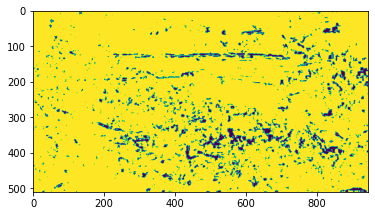

In [232]:
S_ = mask(-S, -0.8)
plt.imshow(S_)
print(np.average(S_))

In [168]:
from scipy.ndimage.morphology import binary_closing, binary_erosion

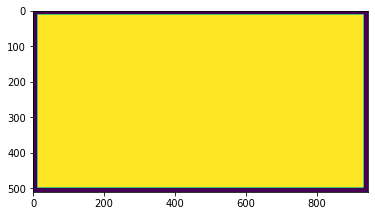

In [169]:
S_er = binary_closing(S_, structure=np.ones((9,9)), iterations=3)
plt.imshow(S_er)